## 📚 Import Required Libraries

In this section, we import the necessary libraries to enable the required functionalities and operations for the project.

In [1]:
import os
from pathlib import Path
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import glob
from tqdm import tqdm
from torchsummary import summary
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    accuracy_score, precision_recall_fscore_support
)
from sklearn.preprocessing import label_binarize
import pandas as pd
from IPython.display import display

## 🗂️ Google Colab Setup

This code mounts Google Drive in a Colab environment, sets a specific directory path in the user's Google Drive, changes the working directory to that path, and then lists the files in that directory.

In [2]:
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive remounted.")
except Exception as e:
    print(f"Error remounting Google Drive: {e}")

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'data_science_CA4/'
GOOGLE_DRIVE_PATH = os.path.join('/content/drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
os.chdir(GOOGLE_DRIVE_PATH)
print(os.listdir('./'))

Mounted at /content/drive
Google Drive remounted.
['flower_photos', 'Task2.ipynb']


## 👀 Visualization

Visualize 5 random images from each class in different columns with `plt.subplots`

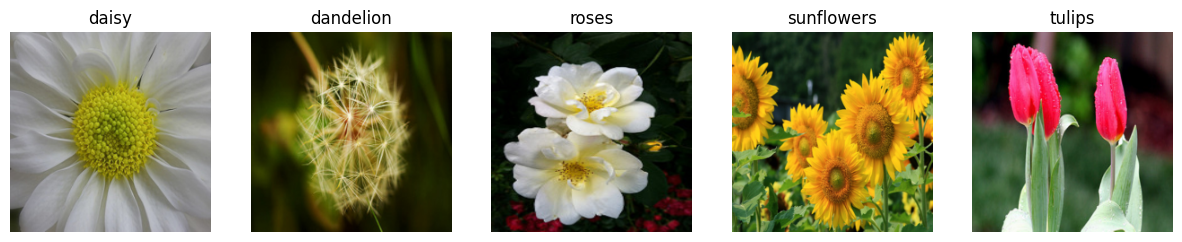

In [3]:
preview_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
sample_ds = datasets.ImageFolder(root=os.path.join('flower_photos', 'train'),
                                 transform=preview_transform)

fig, axes = plt.subplots(1, len(sample_ds.classes), figsize=(15, 5))

class_indices = {}
for i, (img_path, label) in enumerate(sample_ds.imgs):
    class_name = sample_ds.classes[label]
    if class_name not in class_indices:
        class_indices[class_name] = i

# Display one sample image per class
for idx, class_name in enumerate(sample_ds.classes):
    if class_name in class_indices:
        img_index = class_indices[class_name]
        img, label = sample_ds[img_index]
        img_np = img.numpy().transpose(1, 2, 0)
        axes[idx].imshow(img_np)
        axes[idx].set_title(class_name)
        axes[idx].axis('off')
    else:
        print(f"No images found for class: {class_name}")

plt.show()

## ⚙️ Image Preprocessing & Data Augmentation



### 🔄 Data Transforms

1. **Training Transform (`train_transform`)**

   * Resize to 224×224
   * Random rotations up to ±20°
   * Random horizontal flips
   * Random resized crop (scale 90–100%)
   * Color jitter (brightness & contrast)
   * Convert to tensor + ImageNet normalization

2. **Validation/Test Transform (`val_test_transform`)**

   * Resize to 224×224
   * Center crop
   * Convert to tensor + ImageNet normalization

### 📂 Dataset Creation

* **`ImageFolder`** is used to automatically assign class labels based on subfolder names.

  ```python
  train_ds = ImageFolder(root=os.path.join(root_dir, 'train'), transform=train_transform)
  val_ds   = ImageFolder(root=os.path.join(root_dir, 'validation'), transform=val_test_transform)
  test_ds  = ImageFolder(root=os.path.join(root_dir, 'test'), transform=val_test_transform)
  ```

### 🚚 DataLoaders

* **`train_loader`**

  * Shuffles data each epoch.
  * Uses the training transform.
* **`val_loader` & `test_loader`**

  * No shuffling.
  * Uses the deterministic validation/test transform.

All DataLoaders use your specified `batch_size` and `num_workers`.

### 🔙 Returns

A tuple of three `torch.utils.data.DataLoader` objects:

```python
return train_loader, val_loader, test_loader
```

Each loader yields `(images, labels)` batches ready for model training or evaluation.


In [ ]:
def get_dataloaders(root_dir: str,
                    batch_size: int = 32,
                    num_workers: int = 2):

    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Create ImageFolder datasets
    train_ds = datasets.ImageFolder(
        root=os.path.join(root_dir, 'train'),
        transform=train_transform
    )
    val_ds = datasets.ImageFolder(
        root=os.path.join(root_dir, 'validation'),
        transform=val_test_transform
    )
    test_ds = datasets.ImageFolder(
        root=os.path.join(root_dir, 'test'),
        transform=val_test_transform
    )

    # DataLoaders
    train_loader = DataLoader(train_ds,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers)
    val_loader = DataLoader(val_ds,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers)
    test_loader = DataLoader(test_ds,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_workers)

    return train_loader, val_loader, test_loader

## 📄 VGG-16

The VGG-16 model is a convolutional neural network (CNN) architecture that was proposed by the Visual Geometry Group (VGG) at the University of Oxford. It is characterized by its depth, consisting of 16 layers, including 13 convolutional layers and 3 fully connected layers. VGG-16 is renowned for its simplicity and effectiveness, as well as its ability to achieve strong performance on various computer vision tasks, including image classification and object recognition. The model’s architecture features a stack of convolutional layers followed by max-pooling layers, with progressively increasing depth. This design enables the model to learn intricate hierarchical representations of visual features, leading to robust and accurate predictions. Despite its simplicity compared to more recent architectures, VGG-16 remains a popular choice for many deep learning applications due to its versatility and excellent performance.

The ImageNet Large Scale Visual Recognition Challenge (ILSVRC) is an annual competition in computer vision where teams tackle tasks including object localization and image classification. VGG16, proposed by Karen Simonyan and Andrew Zisserman in 2014, achieved top ranks in both tasks, detecting objects from 200 classes and classifying images into 1000 categories. This model achieves 92.7% top-5 test accuracy on the ImageNet dataset which contains 14 million images belonging to 1000 classes.


![](https://i.postimg.cc/qR2ghvVg/VGG-16.png)

The architecture of VGG-16 — Image from [Researchgate.net](https://www.researchgate.net/publication/321829624_Leaf_App_Leaf_recognition_with_deep_convolutional_neural_networks)

### 🔎 breakdown of the VGG-16 architecture

Here’s a breakdown of the VGG-16 architecture:

1. Convolutional Layers (64 filters, 3×3 filters, same padding):
    - Two consecutive convolutional layers with 64 filters each and a filter size of 3×3.
    - Same padding is applied to maintain spatial dimensions.
2. Max Pooling Layer (2×2, stride 2):
    - Max-pooling layer with a pool size of 2×2 and a stride of 2.
3. Convolutional Layers (128 filters, 3×3 filters, same padding):
    - Two consecutive convolutional layers with 128 filters each and a filter size of 3×3.
4. Max Pooling Layer (2×2, stride 2):
    - Max-pooling layer with a pool size of 2×2 and a stride of 2.
5. Convolutional Layers (256 filters, 3×3 filters, same padding):
    - Three consecutive convolutional layers with 256 filters each and a filter size of 3×3.
6. Max Pooling Layer (2×2, stride 2):
    - Max-pooling layer with a pool size of 2×2 and a stride of 2.
7. Convolutional Layers (512 filters, 3×3 filters, same padding):
    - Three sets of three consecutive convolutional layers with 512 filters each and a filter size of 3×3.
8. Max Pooling Layer (2×2, stride 2):
    - Max-pooling layer with a pool size of 2×2 and a stride of 2.
9. Convolutional Layers (512 filters, 3×3 filters, same padding):
    - Three sets of three consecutive convolutional layers with 512 filters each and a filter size of 3×3.
10. Max Pooling Layer (2×2, stride 2):
    - Max-pooling layer with a pool size of 2×2 and a stride of 2.
11. Flattening:
    - Flatten the output feature map.
12. Fully Connected Layers:
    - Three fully connected layers with ReLU activation.
    - First layer with input size 512 and output size 4096.
    - Second layer with input size 4096 and output size 4096.
    - Third layer with input size 4096 and output size 10, corresponding to the 10 classes in the CIFAR10 dataset.
    - Softmax activation is applied to the output of the third fully connected layer for classification.

This architecture follows the specifications provided, including the use of ReLU activation function and the final fully connected layer outputting probabilities for 10 classes using softmax activation.

source: [geeksforgeeks](https://www.geeksforgeeks.org/vgg-16-cnn-model/)

## 🚀Model


### Explanation of VGG16 Layers

- **Conv2d**: Applies convolution for feature extraction from input images.

- **BatchNorm2d**: Normalizes activations to stabilize training and speed up convergence.

- **ReLU**: Introduces non-linearity to help the network learn complex patterns.

- **MaxPool2d**: Reduces the spatial dimensions, making the network more efficient and less sensitive to small translations.

- **Flatten**: Converts the multi-dimensional output of convolutional layers into a 1D vector, making it suitable for fully connected layers.

- **Linear**: Fully connected layers used in the classifier to map features to output classes.

- **Dropout**: Regularization method to prevent overfitting by randomly setting activations to zero during training.

These layers work together to perform feature extraction and classification in the VGG16 architecture.


In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super().__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class VGGNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            VGGBlock(3, 64, 2),
            VGGBlock(64, 128, 2),
            VGGBlock(128, 256, 3),
            VGGBlock(256, 512, 3),
            VGGBlock(512, 512, 3),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### 🔎 sumerry of the model:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VGGNet(num_classes=5).to(device)
summary(model, input_size=(3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
          VGGBlock-6         [-1, 64, 112, 112]               0
            Conv2d-7        [-1, 128, 112, 112]          73,856
              ReLU-8        [-1, 128, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]         147,584
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
         VGGBlock-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         295,168
             ReLU-14          [-1, 256,

## ⚙️Device

Set device to work with (GPU or CPU)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 🔬 Training and Evaluation Functions

This document describes two essential functions for training and evaluating a model: `train_epoch` and `eval_epoch`.

### 1. `train_epoch`

Trains the model for one epoch, calculates the average loss and accuracy, and displays progress with a dynamic progress bar.

#### Key Features:

- Sets the model to training mode.

- Performs forward propagation, loss computation, backward propagation, and parameter updates for each batch.

- Displays a progress bar with real-time updates on loss and accuracy.

### 2. `eval_epoch`

Evaluates the model on validation data, calculating loss and accuracy without updating model parameters.

#### Key Features:

- Sets the model to evaluation mode.

- Disables gradient computations for efficient validation.

- Computes loss and accuracy for each batch without modifying the model.


In [ ]:
def train_epoch(net: torch.nn.Module,
                criterion: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                dataloader: torch.utils.data.DataLoader) -> tuple[float, float]:
    net.train()
    running_loss, correct, total = 0.0, 0, 0
    progress_bar = tqdm(dataloader, desc="Training", unit="batch", leave=True)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{100. * correct / total:.2f}%"
        })

    progress_bar.close()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def eval_epoch(net: torch.nn.Module,
               criterion: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader) -> tuple[float, float]:
    net.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

## ⚒️ Train loop

now we Train our model

Tasks:

- Things that are needed to be printed in each epoch:

  - Number of epoch

  - Train loss

  - Train accuracy

  - Validation loss

  - Validation accuracy

- Save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
data_dir = './flower_photos'
train_loader, val_loader, test_loader = get_dataloaders(data_dir)

num_classes = len(train_loader.dataset.classes)
net = VGGNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

epochs = 10
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    train_loss, train_acc = train_epoch(net, criterion, optimizer, train_loader)
    val_loss, val_acc     = eval_epoch(net, criterion, val_loader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch} Summary:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

# Final test evaluation
test_loss, test_acc = eval_epoch(net, criterion, test_loader)
print(f"\nTest  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")



Epoch 1/10


Training: 100%|██████████| 112/112 [09:25<00:00,  5.05s/batch, Loss=1.4523, Acc=27.78%]


Epoch 1 Summary:
  Train Loss: 1.5457, Train Acc: 0.2778
  Val   Loss: 1.3279, Val   Acc: 0.3875

Epoch 2/10


Training: 100%|██████████| 112/112 [00:58<00:00,  1.92batch/s, Loss=0.9756, Acc=40.23%]


Epoch 2 Summary:
  Train Loss: 1.2938, Train Acc: 0.4023
  Val   Loss: 1.1716, Val   Acc: 0.5250

Epoch 3/10


Training: 100%|██████████| 112/112 [00:57<00:00,  1.96batch/s, Loss=1.1083, Acc=48.00%]


Epoch 3 Summary:
  Train Loss: 1.1871, Train Acc: 0.4800
  Val   Loss: 1.0428, Val   Acc: 0.5750

Epoch 4/10


Training: 100%|██████████| 112/112 [00:57<00:00,  1.93batch/s, Loss=0.8136, Acc=51.44%]


Epoch 4 Summary:
  Train Loss: 1.1340, Train Acc: 0.5144
  Val   Loss: 1.1092, Val   Acc: 0.5500

Epoch 5/10


Training: 100%|██████████| 112/112 [00:57<00:00,  1.94batch/s, Loss=1.2303, Acc=52.73%]


Epoch 5 Summary:
  Train Loss: 1.1185, Train Acc: 0.5273
  Val   Loss: 0.9445, Val   Acc: 0.6500

Epoch 6/10


Training: 100%|██████████| 112/112 [00:57<00:00,  1.95batch/s, Loss=1.1263, Acc=58.20%]


Epoch 6 Summary:
  Train Loss: 1.0485, Train Acc: 0.5820
  Val   Loss: 1.0105, Val   Acc: 0.5250

Epoch 7/10


Training: 100%|██████████| 112/112 [00:57<00:00,  1.95batch/s, Loss=1.2844, Acc=61.34%]


Epoch 7 Summary:
  Train Loss: 0.9775, Train Acc: 0.6134
  Val   Loss: 1.0329, Val   Acc: 0.5750

Epoch 8/10


Training: 100%|██████████| 112/112 [00:57<00:00,  1.95batch/s, Loss=0.8976, Acc=64.28%]


Epoch 8 Summary:
  Train Loss: 0.9247, Train Acc: 0.6428
  Val   Loss: 0.8798, Val   Acc: 0.6500

Epoch 9/10


Training: 100%|██████████| 112/112 [00:57<00:00,  1.95batch/s, Loss=0.6998, Acc=65.63%]


Epoch 9 Summary:
  Train Loss: 0.8754, Train Acc: 0.6563
  Val   Loss: 0.7953, Val   Acc: 0.6625

Epoch 10/10


Training: 100%|██████████| 112/112 [00:57<00:00,  1.96batch/s, Loss=1.1267, Acc=66.69%]


Epoch 10 Summary:
  Train Loss: 0.8487, Train Acc: 0.6669
  Val   Loss: 0.8357, Val   Acc: 0.6875

Test  Loss: 1.0137, Test  Acc: 0.5600


## 📊 Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

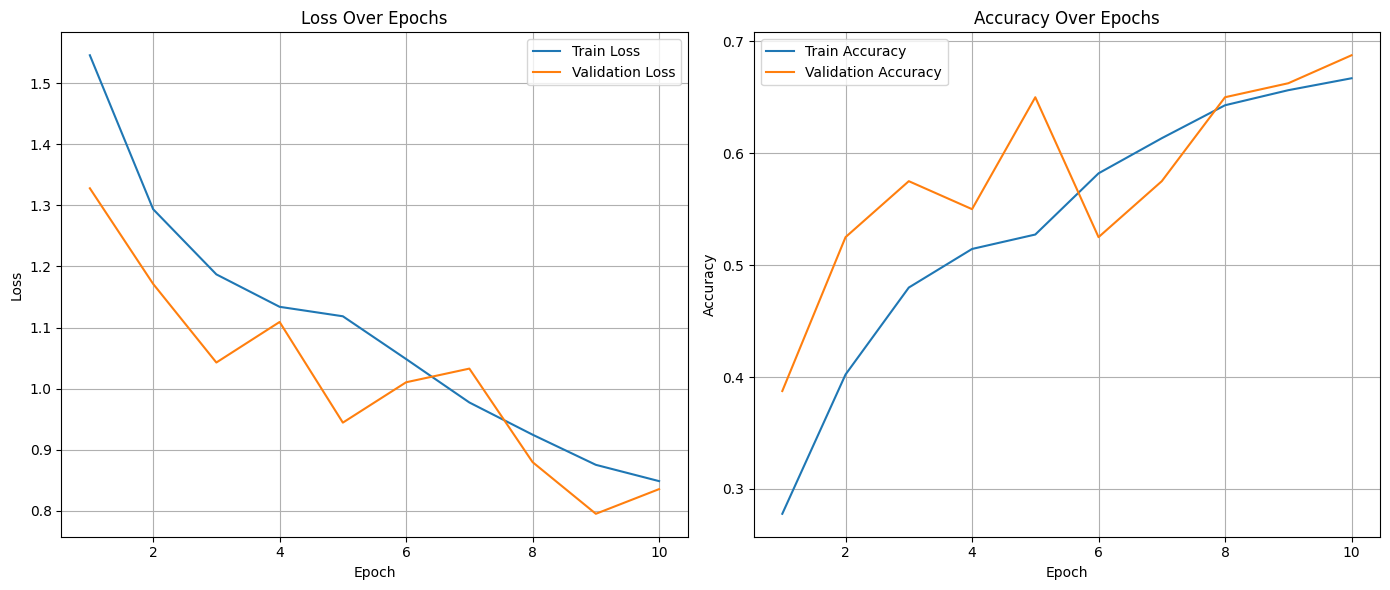

In [ ]:
def plot_metrics(history):
    epochs = len(history['train_loss'])
    epochs_range = range(1, epochs + 1)

    # Plot Loss
    plt.figure(figsize=(14, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Show plots
    plt.tight_layout()
    plt.show()

plot_metrics(history)


## 💡 Fine-Tuning a Pretrained ResNet50

1. **Step 1: Train Head Only**

   * Freeze all convolutional layers (`param.requires_grad = False`)

   * Unfreeze the new `fc` head

   * Optimizer: `Adam(resnet.fc.parameters(), lr=1e-3)`

   * Train for 5 epochs

2. **Step 2: Fine-Tune Last Block + Head**

   * Unfreeze `layer4` (the final ResNet block) and `fc` only

   * Optimizer: `Adam(filter(...), lr=1e-4)`

   * Train for 5 epochs

3. **Step 3: Fine-Tune Entire Network**

   * Unfreeze all layers (`param.requires_grad = True`)

   * Optimizer: `Adam(resnet.parameters(), lr=1e-5)`

   * Train for 5 epochs

**Key points:**

* **Parameter counting** via `count_params` to track how many weights are trainable at each stage.

* **Three-stage schedule**: head-only → last block + head → full network.

* **Learning rate decay** each stage to progressively fine-tune with smaller updates.



In [ ]:
num_classes = len(train_loader.dataset.classes)

# Load pretrained ResNet50
resnet = models.resnet50(pretrained=True)

# Replace the final FC layer
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(device)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total params:", count_params(resnet))

# common criterion
criterion = nn.CrossEntropyLoss()

#-----------------------------------------------------------------------------------------
# first step: Freeze all conv layers, train only the new head
for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)
print("\n Step 1: training head only:")
print("Trainable params:", count_params(resnet))

# train for 5 epochs
for epoch in range(1, 6):
    train_loss, train_acc = train_epoch(resnet, criterion, optimizer, train_loader)
    val_loss, val_acc     = eval_epoch(resnet, criterion, val_loader)

#-----------------------------------------------------------------------------------------
# second step: Unfreeze last conv block (layer4) + head
for name, param in resnet.named_parameters():
    param.requires_grad = name.startswith("layer4") or name.startswith("fc")

optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-4)
print("\n Step 2: fine-tune layer4 + head:")
print("Trainable params:", count_params(resnet))

# train for 5 epochs
for epoch in range(1, 6):
    train_loss, train_acc = train_epoch(resnet, criterion, optimizer, train_loader)
    val_loss, val_acc = eval_epoch(resnet, criterion, val_loader)

#-----------------------------------------------------------------------------------------
# third step: Unfreeze all layers
for param in resnet.parameters():
    param.requires_grad = True

optimizer = optim.Adam(resnet.parameters(), lr=1e-5)
print("\n Step 3: fine-tune entire network:")
print("Trainable params:", count_params(resnet))

# train for 5 epochs
for epoch in range(1, 6):
    train_loss, train_acc = train_epoch(resnet, criterion, optimizer, train_loader)
    val_loss, val_acc = eval_epoch(resnet, criterion, val_loader)

# Final test evaluation
test_loss, test_acc = eval_epoch(resnet, criterion, test_loader)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


Total params: 23518277

 Step 1: training head only:
Trainable params: 10245


Training: 100%|██████████| 112/112 [00:30<00:00,  3.64batch/s, Loss=0.9409, Acc=87.38%]



 Step 2: fine-tune layer4 + head:
Trainable params: 14974981


Training: 100%|██████████| 112/112 [00:33<00:00,  3.37batch/s, Loss=0.0105, Acc=97.67%]



 Step 3: fine-tune entire network:
Trainable params: 23518277


Training: 100%|██████████| 112/112 [00:40<00:00,  2.76batch/s, Loss=0.0024, Acc=99.72%]



Test Loss: 0.5691, Test Acc: 0.8800


## 🧪 Evaluation

Test our trained model (using the Test Dataloader that we have).

**Purpose:**

Runs inference on `dataloader`, then plots:

1. **Confusion Matrix**

2. **Per-class ROC curves** (with AUC)

3. Displays overall **Accuracy**, **Precision**, **Recall**, and **F1-score** in a table.

**Args:**

* `model`: trained PyTorch model (set to `.eval()` internally)

* `dataloader`: test or validation loader

* `class_names`: list of class label strings

* `device`: target device (`cpu` or `cuda`)


In [ ]:

def evaluate_and_plot(model, dataloader, class_names, device):
    model.to(device).eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.vstack(all_probs)

    # 1) Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # 2) ROC Curves per class
    y_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves by Class")
    plt.legend(loc="lower right", fontsize="small", ncol=2)
    plt.tight_layout()
    plt.show()

    # 3) Classification Metrics
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    df = pd.DataFrame({
        'Accuracy': [acc],
        'Precision': [precision],
        'Recall': [recall],
        'F1-score': [f1]
    }, index=['Overall'])
    display(df)


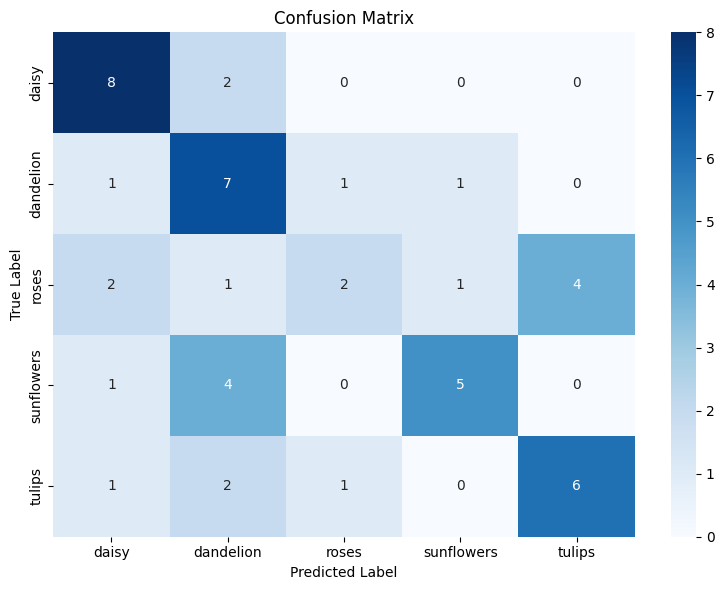

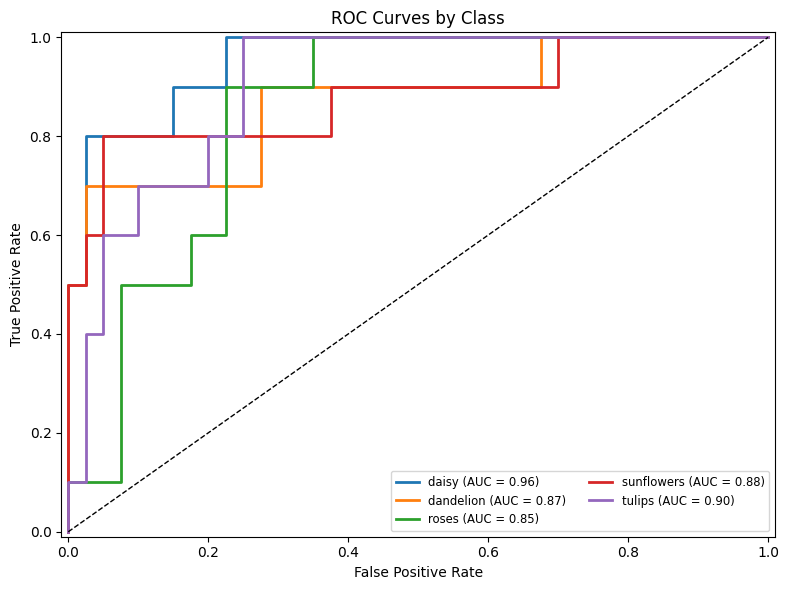

,Accuracy,Precision,Recall,F1-score
Overall,0.56,0.573434,0.56,0.541613


In [ ]:
evaluate_and_plot(net, test_loader, train_loader.dataset.classes, device)

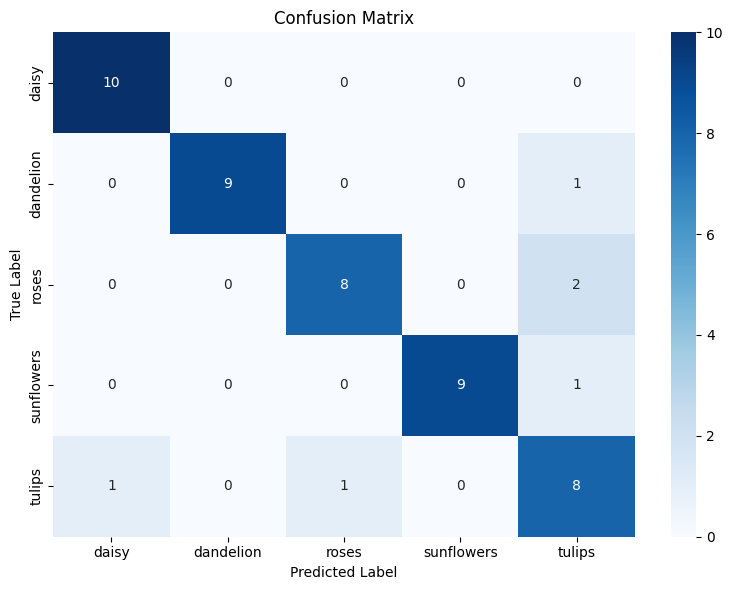

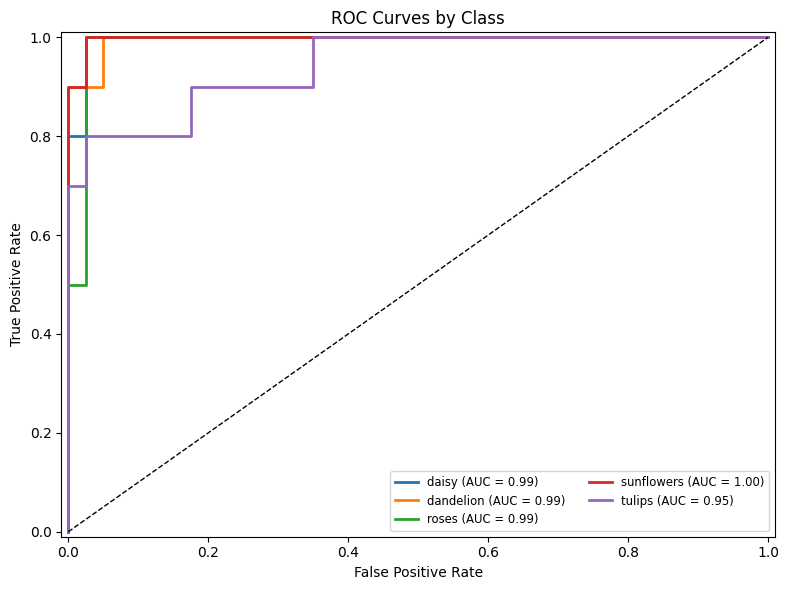

,Accuracy,Precision,Recall,F1-score
Overall,0.88,0.892929,0.88,0.883299


In [ ]:
evaluate_and_plot(resnet, test_loader, train_loader.dataset.classes, device)
